In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

In [9]:
from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [10]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

# Clustering

## Split the clusters which have a temporal gap

In [11]:
time_thresh = 1/6
dist_thresh=0.25

In [12]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [15]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask
from helper__metric_box__explore import eval_synth_data

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

## Batch processing

### 1 Stay

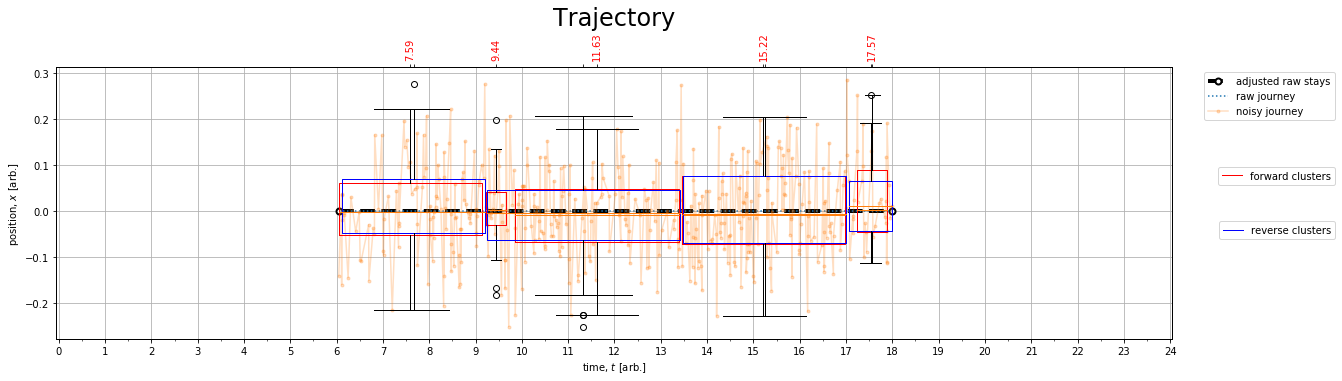

In [16]:
stays = get1()
#stays = gete(0.50, (5.66))

time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
len(clusters)
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
len(clusters_rev)

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [17]:
scores = []

total = 100

for _ in range(total):

    stays = get1()
        #stays = gete(0.50, (5.66))

    try:
        score = []

        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)

        clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
        prec, rec, _ = eval_synth_data(segments, time_arr, clusters)
        score.extend([len(clusters), prec, rec])

        clusters = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)            
        prec, rec, _ = eval_synth_data(segments, time_arr, clusters)
        score.extend([len(clusters), prec, rec])

        scores.append(score)

    except:
        pass

scores = np.array(scores)

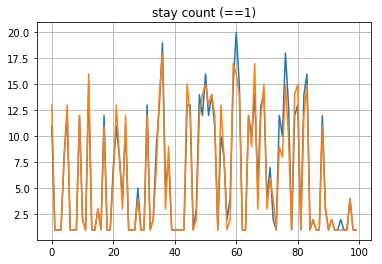

In [18]:
plt.plot(scores[:,0])
plt.plot(scores[:,3])
plt.title('stay count (==1)')
plt.grid()

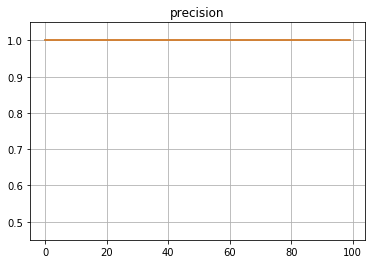

In [19]:
plt.plot(scores[:,1])
plt.plot(scores[:,4])
plt.title('precision')
plt.ylim(0.45,1.05)
plt.grid()

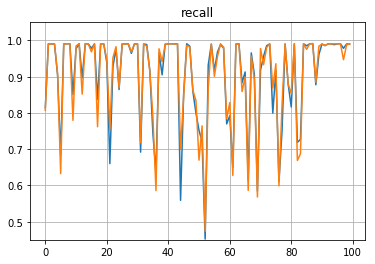

In [20]:
plt.plot(scores[:,2])
plt.plot(scores[:,5])
plt.title('recall')
plt.ylim(0.45,1.05)
plt.grid()